<a href="https://colab.research.google.com/github/sherry-ml/EVA7/blob/main/Normalization_Session_6_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR,OneCycleLR
from tqdm import tqdm

In [2]:
!pip install torchsummary
from torchsummary import summary

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
mkdir /class_def

In [5]:
cp /content/drive/MyDrive/EVA7/Session_6/model_class.py /class_def/

In [6]:
cd /class_def

/class_def


In [7]:
ls 

model_class.py


In [8]:
import model_class
from model_class import Net

In [9]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [10]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Viewing Model Parameters

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [13]:
def view_model_summary(norm_type='BN'):
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(device)
  test_model = Net(norm_type).to(device)
  summary(test_model, input_size=(1, 28, 28))
  print(test_model)

In [14]:
view_model_summary()

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14            [-

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [15]:
view_model_summary('LN')

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
         GroupNorm-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
         GroupNorm-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
        GroupNorm-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14            [-

In [16]:
view_model_summary('GN')

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
         GroupNorm-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
         GroupNorm-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
        GroupNorm-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14            [-

In [17]:
def train(model, device, train_loader, optimizer, epoch, scheduler, train_losses, train_acc, lambda_l1):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #loss = F.nll_loss(y_pred, target)
    loss = F.nll_loss(y_pred, target, reduction='sum')

    if(lambda_l1 > 0):
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1


    train_loss += loss.item()
    

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    #processed += len(data)

  #pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_losses.append(train_loss/len(train_loader.dataset))
  train_acc.append(100*correct/len(train_loader.dataset))

  print(f'\n Average Training Loss={train_loss/len(train_loader.dataset)}, Accuracy={100*correct/len(train_loader.dataset)}')

def test(model, device, test_loader,test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [18]:
len(test_loader.dataset), len(train_loader.dataset)

(10000, 60000)

In [19]:
train_losses_BN = []
test_losses_BN = []
train_acc_BN = []
test_acc_BN = []

train_losses_LN = []
test_losses_LN = []
train_acc_LN = []
test_acc_LN = []

train_losses_GN = []
test_losses_GN = []
train_acc_GN = []
test_acc_GN = []

wrong_predictions_BN = []
wrong_predictions_LN = []
wrong_predictions_GN = []

def train_test_model(norm_type='BN', EPOCHS=20):

  torch.manual_seed(42)
  lambda_l1 = 0
  model =  Net(norm_type).to(device)
  print(model)
  optimizer = optim.Adam(model.parameters(), lr=0.05)
  scheduler = OneCycleLR(optimizer, max_lr=0.05,epochs=EPOCHS,steps_per_epoch=len(train_loader))
  if(norm_type == 'BN'):
    train_losses = train_losses_BN
    train_acc    = train_acc_BN
    test_losses  = test_losses_BN
    test_acc     = test_acc_BN
    lambda_l1 = 0.002
    wrong_prediction_list = wrong_predictions_BN
  elif(norm_type == 'LN'):
    train_losses = train_losses_LN
    train_acc    = train_acc_LN
    test_losses  = test_losses_LN
    test_acc     = test_acc_LN
    wrong_prediction_list = wrong_predictions_LN
  else:
    train_losses = train_losses_GN
    train_acc    = train_acc_GN
    test_losses  = test_losses_GN
    test_acc     = test_acc_GN
    wrong_prediction_list = wrong_predictions_GN
  
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler,train_losses, train_acc, lambda_l1)
    test(model, device, test_loader, test_losses, test_acc)
  
  model.eval()
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    match = pred.eq(labels.view_as(pred)).to('cpu').numpy()
    for j, i in enumerate(match):
      if(i == False):
        wrong_prediction_list.append((images[j], pred[j].item(), labels[j].item()))

  print(f'Total Number of incorrectly predicted images by model type {norm_type} is {len(wrong_prediction_list)}')


In [20]:
train_test_model()
# Running Model Using BatchNorm + L1

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.02, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.02, inplace=False)
  )
  (trans): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.02, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 469/469 [00:14<00:00, 31.53it/s]


 Average Training Loss=0.6122536835670471, Accuracy=87.98666666666666



Test set: Average loss: 0.0993, Accuracy: 9752/10000 (97.52%)

EPOCH: 1


100%|██████████| 469/469 [00:15<00:00, 30.68it/s]


 Average Training Loss=0.11080039645036062, Accuracy=97.26



Test set: Average loss: 0.0864, Accuracy: 9723/10000 (97.23%)

EPOCH: 2


100%|██████████| 469/469 [00:15<00:00, 30.26it/s]


 Average Training Loss=0.10005678021510442, Accuracy=97.37



Test set: Average loss: 0.1723, Accuracy: 9451/10000 (94.51%)

EPOCH: 3


100%|██████████| 469/469 [00:15<00:00, 30.06it/s]


 Average Training Loss=0.10292177344163259, Accuracy=97.54166666666667



Test set: Average loss: 0.0622, Accuracy: 9808/10000 (98.08%)

EPOCH: 4


100%|██████████| 469/469 [00:14<00:00, 31.33it/s]


 Average Training Loss=0.10702032709916433, Accuracy=97.72



Test set: Average loss: 0.0470, Accuracy: 9854/10000 (98.54%)

EPOCH: 5


100%|██████████| 469/469 [00:14<00:00, 31.58it/s]


 Average Training Loss=0.10653405752976736, Accuracy=97.94333333333333



Test set: Average loss: 0.1049, Accuracy: 9675/10000 (96.75%)

EPOCH: 6


100%|██████████| 469/469 [00:15<00:00, 30.96it/s]


 Average Training Loss=0.10712503055731455, Accuracy=98.04



Test set: Average loss: 0.0483, Accuracy: 9851/10000 (98.51%)

EPOCH: 7


100%|██████████| 469/469 [00:15<00:00, 30.48it/s]


 Average Training Loss=0.1093226862668991, Accuracy=98.07



Test set: Average loss: 0.0993, Accuracy: 9684/10000 (96.84%)

EPOCH: 8


100%|██████████| 469/469 [00:15<00:00, 31.09it/s]


 Average Training Loss=0.1069971858739853, Accuracy=98.20666666666666



Test set: Average loss: 0.0352, Accuracy: 9889/10000 (98.89%)

EPOCH: 9


100%|██████████| 469/469 [00:15<00:00, 30.48it/s]


 Average Training Loss=0.10506444159348806, Accuracy=98.36666666666666



Test set: Average loss: 0.0435, Accuracy: 9857/10000 (98.57%)

EPOCH: 10


100%|██████████| 469/469 [00:14<00:00, 31.50it/s]


 Average Training Loss=0.10429242061773936, Accuracy=98.355



Test set: Average loss: 0.0330, Accuracy: 9896/10000 (98.96%)

EPOCH: 11


100%|██████████| 469/469 [00:15<00:00, 30.34it/s]


 Average Training Loss=0.10340340443452199, Accuracy=98.455



Test set: Average loss: 0.0325, Accuracy: 9893/10000 (98.93%)

EPOCH: 12


100%|██████████| 469/469 [00:15<00:00, 30.10it/s]


 Average Training Loss=0.09645547819932301, Accuracy=98.565



Test set: Average loss: 0.0370, Accuracy: 9873/10000 (98.73%)

EPOCH: 13


100%|██████████| 469/469 [00:15<00:00, 30.89it/s]


 Average Training Loss=0.0907525003115336, Accuracy=98.72333333333333



Test set: Average loss: 0.0296, Accuracy: 9912/10000 (99.12%)

EPOCH: 14


100%|██████████| 469/469 [00:15<00:00, 29.63it/s]


 Average Training Loss=0.08774751822153727, Accuracy=98.78666666666666



Test set: Average loss: 0.0253, Accuracy: 9934/10000 (99.34%)

EPOCH: 15


100%|██████████| 469/469 [00:15<00:00, 31.12it/s]


 Average Training Loss=0.07672959211667378, Accuracy=99.01833333333333



Test set: Average loss: 0.0265, Accuracy: 9914/10000 (99.14%)

EPOCH: 16


100%|██████████| 469/469 [00:15<00:00, 30.12it/s]


 Average Training Loss=0.07165367711385091, Accuracy=99.15833333333333



Test set: Average loss: 0.0199, Accuracy: 9942/10000 (99.42%)

EPOCH: 17


100%|██████████| 469/469 [00:15<00:00, 31.13it/s]


 Average Training Loss=0.06643304069042205, Accuracy=99.225



Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


100%|██████████| 469/469 [00:15<00:00, 30.76it/s]


 Average Training Loss=0.06262140745321909, Accuracy=99.32833333333333



Test set: Average loss: 0.0181, Accuracy: 9945/10000 (99.45%)

EPOCH: 19


100%|██████████| 469/469 [00:15<00:00, 31.12it/s]


 Average Training Loss=0.060968115115165714, Accuracy=99.335



Test set: Average loss: 0.0185, Accuracy: 9940/10000 (99.40%)

Total Number of incorrectly predicted images by model type BN is 60


In [21]:
len(wrong_predictions_BN), len(wrong_predictions_LN), len(wrong_predictions_GN)

(60, 0, 0)

In [22]:
wrong_predictions_BN[0][1], wrong_predictions_BN[0][2], wrong_predictions_BN[6][1], wrong_predictions_BN[6][2]

(5, 6, 6, 0)

In [23]:
train_test_model('LN')
#Running model using Layer Normalization

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): GroupNorm(1, 8, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.02, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): GroupNorm(1, 16, eps=1e-05, affine=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.02, inplace=False)
  )
  (trans): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): GroupNorm(1, 8, eps=1e-05, affine=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.02, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): GroupNorm(1, 8, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.02, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): GroupNor

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 469/469 [00:14<00:00, 32.78it/s]


 Average Training Loss=0.820431977558136, Accuracy=80.28



Test set: Average loss: 0.1696, Accuracy: 9529/10000 (95.29%)

EPOCH: 1


100%|██████████| 469/469 [00:14<00:00, 31.55it/s]


 Average Training Loss=0.16764013663927715, Accuracy=95.05833333333334



Test set: Average loss: 0.0985, Accuracy: 9715/10000 (97.15%)

EPOCH: 2


100%|██████████| 469/469 [00:14<00:00, 31.79it/s]


 Average Training Loss=0.12079787954886755, Accuracy=96.245



Test set: Average loss: 0.0774, Accuracy: 9742/10000 (97.42%)

EPOCH: 3


100%|██████████| 469/469 [00:14<00:00, 32.65it/s]


 Average Training Loss=0.10847832571069399, Accuracy=96.665



Test set: Average loss: 0.0617, Accuracy: 9822/10000 (98.22%)

EPOCH: 4


100%|██████████| 469/469 [00:14<00:00, 32.43it/s]


 Average Training Loss=0.08689365586439768, Accuracy=97.31333333333333



Test set: Average loss: 0.0534, Accuracy: 9842/10000 (98.42%)

EPOCH: 5


100%|██████████| 469/469 [00:14<00:00, 32.09it/s]


 Average Training Loss=0.07599477928777536, Accuracy=97.66



Test set: Average loss: 0.0633, Accuracy: 9819/10000 (98.19%)

EPOCH: 6


100%|██████████| 469/469 [00:14<00:00, 31.83it/s]


 Average Training Loss=0.07488643392423788, Accuracy=97.74



Test set: Average loss: 0.0536, Accuracy: 9840/10000 (98.40%)

EPOCH: 7


100%|██████████| 469/469 [00:14<00:00, 31.75it/s]


 Average Training Loss=0.0633543029765288, Accuracy=98.00166666666667



Test set: Average loss: 0.0407, Accuracy: 9875/10000 (98.75%)

EPOCH: 8


100%|██████████| 469/469 [00:14<00:00, 32.65it/s]


 Average Training Loss=0.059883120879530904, Accuracy=98.11166666666666



Test set: Average loss: 0.0410, Accuracy: 9884/10000 (98.84%)

EPOCH: 9


100%|██████████| 469/469 [00:14<00:00, 33.22it/s]


 Average Training Loss=0.0539110123599569, Accuracy=98.33666666666667



Test set: Average loss: 0.0306, Accuracy: 9904/10000 (99.04%)

EPOCH: 10


100%|██████████| 469/469 [00:14<00:00, 32.96it/s]


 Average Training Loss=0.051872999362150826, Accuracy=98.375



Test set: Average loss: 0.0395, Accuracy: 9880/10000 (98.80%)

EPOCH: 11


100%|██████████| 469/469 [00:14<00:00, 32.16it/s]


 Average Training Loss=0.0461649907891949, Accuracy=98.55



Test set: Average loss: 0.0318, Accuracy: 9900/10000 (99.00%)

EPOCH: 12


100%|██████████| 469/469 [00:14<00:00, 32.15it/s]


 Average Training Loss=0.04363287482857704, Accuracy=98.655



Test set: Average loss: 0.0306, Accuracy: 9906/10000 (99.06%)

EPOCH: 13


100%|██████████| 469/469 [00:14<00:00, 33.47it/s]


 Average Training Loss=0.03880462573791544, Accuracy=98.83666666666667



Test set: Average loss: 0.0272, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


100%|██████████| 469/469 [00:14<00:00, 32.60it/s]


 Average Training Loss=0.03698856074760357, Accuracy=98.83833333333334



Test set: Average loss: 0.0259, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


100%|██████████| 469/469 [00:14<00:00, 31.95it/s]


 Average Training Loss=0.03125975822831194, Accuracy=99.03666666666666



Test set: Average loss: 0.0214, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


100%|██████████| 469/469 [00:14<00:00, 32.44it/s]


 Average Training Loss=0.027718759624908367, Accuracy=99.10666666666667



Test set: Average loss: 0.0177, Accuracy: 9952/10000 (99.52%)

EPOCH: 17


100%|██████████| 469/469 [00:14<00:00, 33.22it/s]


 Average Training Loss=0.02452796816676855, Accuracy=99.23333333333333



Test set: Average loss: 0.0183, Accuracy: 9949/10000 (99.49%)

EPOCH: 18


100%|██████████| 469/469 [00:14<00:00, 33.14it/s]


 Average Training Loss=0.020659483033418656, Accuracy=99.35333333333334



Test set: Average loss: 0.0187, Accuracy: 9948/10000 (99.48%)

EPOCH: 19


100%|██████████| 469/469 [00:14<00:00, 32.42it/s]


 Average Training Loss=0.02021767915400366, Accuracy=99.36833333333334



Test set: Average loss: 0.0182, Accuracy: 9949/10000 (99.49%)

Total Number of incorrectly predicted images by model type LN is 51


In [24]:
len(wrong_predictions_BN), len(wrong_predictions_LN), len(wrong_predictions_GN)

(60, 51, 0)

In [25]:
wrong_predictions_LN[0][1], wrong_predictions_LN[0][2], wrong_predictions_LN[6][1], wrong_predictions_LN[6][2]

(5, 6, 3, 2)

In [26]:
train_test_model('GN')
#Running model using Group Normalization

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): GroupNorm(2, 8, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.02, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): GroupNorm(2, 16, eps=1e-05, affine=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.02, inplace=False)
  )
  (trans): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): GroupNorm(2, 8, eps=1e-05, affine=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.02, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): GroupNorm(2, 8, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.02, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): GroupNor

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 469/469 [00:14<00:00, 32.93it/s]


 Average Training Loss=0.8112515829086304, Accuracy=80.05333333333333



Test set: Average loss: 0.1330, Accuracy: 9673/10000 (96.73%)

EPOCH: 1


100%|██████████| 469/469 [00:14<00:00, 31.71it/s]


 Average Training Loss=0.1581210858821869, Accuracy=95.325



Test set: Average loss: 0.0894, Accuracy: 9743/10000 (97.43%)

EPOCH: 2


100%|██████████| 469/469 [00:14<00:00, 32.00it/s]


 Average Training Loss=0.10972007077932358, Accuracy=96.645



Test set: Average loss: 0.0639, Accuracy: 9808/10000 (98.08%)

EPOCH: 3


100%|██████████| 469/469 [00:14<00:00, 33.07it/s]


 Average Training Loss=0.09899499001105626, Accuracy=96.95166666666667



Test set: Average loss: 0.0759, Accuracy: 9773/10000 (97.73%)

EPOCH: 4


100%|██████████| 469/469 [00:14<00:00, 32.70it/s]


 Average Training Loss=0.08609737843672434, Accuracy=97.39



Test set: Average loss: 0.0396, Accuracy: 9884/10000 (98.84%)

EPOCH: 5


100%|██████████| 469/469 [00:14<00:00, 31.71it/s]


 Average Training Loss=0.07807846742073694, Accuracy=97.555



Test set: Average loss: 0.0555, Accuracy: 9824/10000 (98.24%)

EPOCH: 6


100%|██████████| 469/469 [00:14<00:00, 32.64it/s]


 Average Training Loss=0.06787921757797401, Accuracy=97.895



Test set: Average loss: 0.0607, Accuracy: 9808/10000 (98.08%)

EPOCH: 7


100%|██████████| 469/469 [00:14<00:00, 33.37it/s]


 Average Training Loss=0.06383313636084398, Accuracy=98.08333333333333



Test set: Average loss: 0.0394, Accuracy: 9873/10000 (98.73%)

EPOCH: 8


100%|██████████| 469/469 [00:14<00:00, 33.01it/s]


 Average Training Loss=0.055850034156441686, Accuracy=98.28



Test set: Average loss: 0.0453, Accuracy: 9853/10000 (98.53%)

EPOCH: 9


100%|██████████| 469/469 [00:13<00:00, 33.50it/s]


 Average Training Loss=0.05180269958078861, Accuracy=98.385



Test set: Average loss: 0.0337, Accuracy: 9889/10000 (98.89%)

EPOCH: 10


100%|██████████| 469/469 [00:14<00:00, 31.98it/s]


 Average Training Loss=0.04716276153971752, Accuracy=98.51



Test set: Average loss: 0.0305, Accuracy: 9902/10000 (99.02%)

EPOCH: 11


100%|██████████| 469/469 [00:14<00:00, 31.80it/s]


 Average Training Loss=0.04465009323259195, Accuracy=98.56666666666666



Test set: Average loss: 0.0323, Accuracy: 9914/10000 (99.14%)

EPOCH: 12


100%|██████████| 469/469 [00:14<00:00, 33.08it/s]


 Average Training Loss=0.04129518427327275, Accuracy=98.805



Test set: Average loss: 0.0304, Accuracy: 9905/10000 (99.05%)

EPOCH: 13


100%|██████████| 469/469 [00:14<00:00, 32.53it/s]


 Average Training Loss=0.03570274727170666, Accuracy=98.92333333333333



Test set: Average loss: 0.0254, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


100%|██████████| 469/469 [00:14<00:00, 32.98it/s]


 Average Training Loss=0.034629703683157764, Accuracy=98.91833333333334



Test set: Average loss: 0.0282, Accuracy: 9917/10000 (99.17%)

EPOCH: 15


100%|██████████| 469/469 [00:14<00:00, 32.44it/s]


 Average Training Loss=0.029239352349440258, Accuracy=99.07333333333334



Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

EPOCH: 16


100%|██████████| 469/469 [00:14<00:00, 32.82it/s]


 Average Training Loss=0.025102138942231733, Accuracy=99.17333333333333



Test set: Average loss: 0.0244, Accuracy: 9936/10000 (99.36%)

EPOCH: 17


100%|██████████| 469/469 [00:14<00:00, 32.34it/s]


 Average Training Loss=0.02193758797434469, Accuracy=99.35666666666667



Test set: Average loss: 0.0180, Accuracy: 9947/10000 (99.47%)

EPOCH: 18


100%|██████████| 469/469 [00:14<00:00, 33.12it/s]


 Average Training Loss=0.01944320500617226, Accuracy=99.42666666666666



Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)

EPOCH: 19


100%|██████████| 469/469 [00:14<00:00, 32.66it/s]


 Average Training Loss=0.018002404702454806, Accuracy=99.43666666666667



Test set: Average loss: 0.0181, Accuracy: 9947/10000 (99.47%)

Total Number of incorrectly predicted images by model type GN is 53


In [27]:
len(wrong_predictions_BN), len(wrong_predictions_LN), len(wrong_predictions_GN)


(60, 51, 53)

In [28]:
wrong_predictions_GN[0][1], wrong_predictions_GN[0][2], wrong_predictions_LN[6][1], wrong_predictions_GN[6][2]

(5, 6, 3, 9)

In [29]:
import matplotlib.pyplot as plt

def display_incorrect_images(ll=wrong_predictions_BN, n=10 ):
  display_images = ll[:n]
  index = 0
  fig = plt.figure(figsize=(10,12))
  for img in display_images:
    image = img[0].squeeze().to('cpu').numpy()
    pred = img[1]
    actual = img[2]
    ax = fig.add_subplot(5, 2, index+1)
    ax.axis('off')
    ax.set_title(f'\n Predicted Label {pred} \n Actual Label : {actual}',fontsize=10) 
    ax.imshow(image, cmap='gray_r')
    index = index + 1
  plt.show()

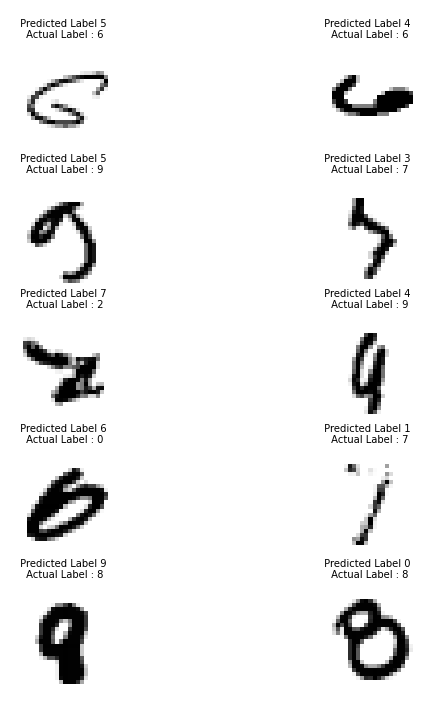

In [30]:
display_incorrect_images(wrong_predictions_BN)

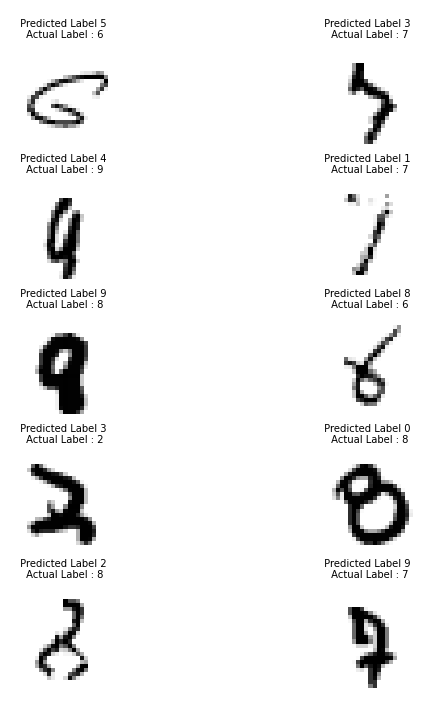

In [31]:
display_incorrect_images(wrong_predictions_LN)

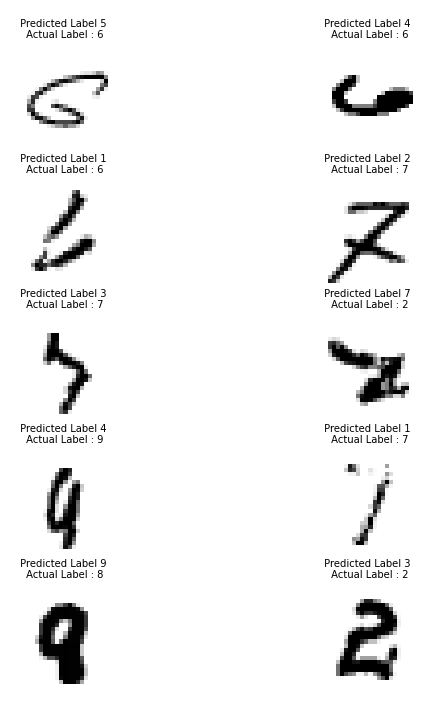

In [32]:
display_incorrect_images(wrong_predictions_GN)

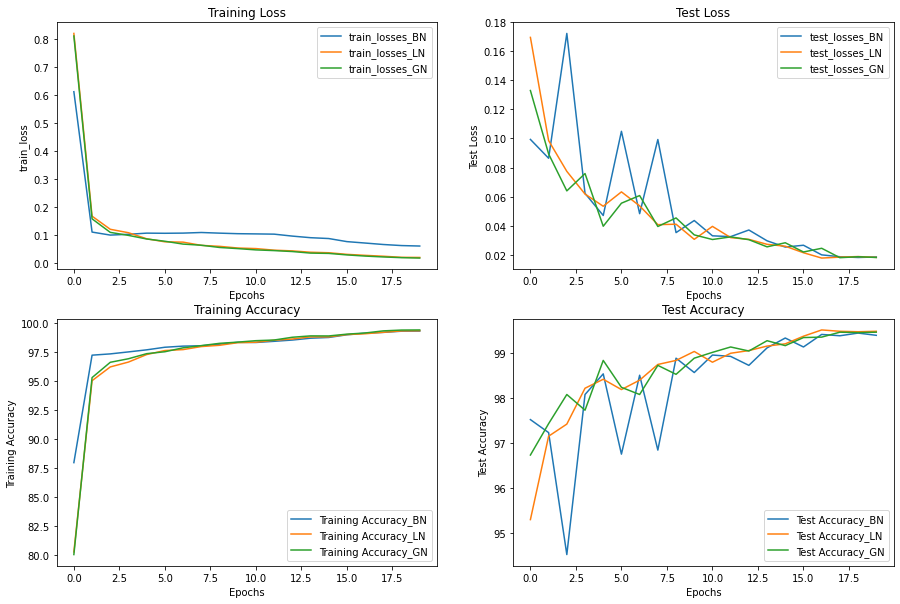

In [33]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses_BN, label='train_losses_BN')
axs[0, 0].plot(train_losses_LN, label='train_losses_LN')
axs[0, 0].plot(train_losses_GN, label='train_losses_GN')
axs[0,0].legend(loc='upper right')
axs[0,0].set_xlabel('Epcohs')
axs[0,0].set_ylabel('train_loss')
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_BN, label='Training Accuracy_BN')
axs[1, 0].plot(train_acc_LN, label='Training Accuracy_LN')
axs[1, 0].plot(train_acc_GN, label='Training Accuracy_GN')
axs[1,0].legend(loc='lower right')
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylabel('Training Accuracy')
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses_BN, label='test_losses_BN')
axs[0, 1].plot(test_losses_LN, label='test_losses_LN')
axs[0, 1].plot(test_losses_GN, label='test_losses_GN')
axs[0,1].legend(loc='upper right')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('Test Loss')
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_BN, label='Test Accuracy_BN')
axs[1, 1].plot(test_acc_LN, label='Test Accuracy_LN')
axs[1, 1].plot(test_acc_GN, label='Test Accuracy_GN')
axs[1,1].legend(loc='lower right')
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylabel('Test Accuracy')
axs[1, 1].set_title("Test Accuracy")

plt.show()